# Factors influencing rider perfomance
Purpose of this presentation is to find out which factors influecne rider perfomance measured by speed.  
Some setup:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
files = ["201909-citibike-tripdata.csv"]
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs)

Let's clean our data a little bit.

In [2]:
df["starttime"]= pd.to_datetime(df["starttime"], format="%Y-%m-%d %H:%M:%S.%f")
df["stoptime"] = pd.to_datetime(df["stoptime"], format="%Y-%m-%d %H:%M:%S.%f")
df = df.drop(df.index[(df['tripduration'] > 7200)])
df = df[df['tripduration'] > 120]
df = df[(df['birth year'] < 2000) & (df['birth year'] > 1960)]
df = df.drop(df.index[(df['start station id'] == df['end station id'])])

In order to calculate average speed of the trip, we need to know distance and time which it took. We do know time - it's `tripduration` field. What about distance? We have only start station latitude/longtitude and the same for end station. Surely we could have used some map API to get shortest route length, but on such large datasets as New York bikes usage data it would take ages to make request and fetch response for every record. We also can calculate staight distance between start station and end station, but it probably will be pretty far from actual trip distance. So we have to find another way.  
Where do people use bikes the most? Let's check the map.

In [3]:
def stationsmap(df, parameter):
    idn = parameter + " station id"
    stations = df.drop_duplicates(idn)
    count = df.groupby(idn).count().rename(columns = {'tripduration' : 'count'})['count']
    swc = pd.merge(stations, count, left_on = idn, right_index = True)
    margin = 0.01
    lats = list(swc[parameter + " station latitude"])
    lons = list(swc[parameter + " station longitude"])
    lat_min = min(lats) - margin
    lat_max = max(lats) + margin
    lon_min = min(lons) - margin
    lon_max = max(lons) + margin
    
    plt.figure(figsize=(24,12))
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()

    # convert lat and lon to map projection coordinates
    mlons, mlats = m(lons, lats)
    siz = list(swc["count"] / 100)
    
    plt.scatter(mlons, mlats, marker = 'o', color='g', zorder=5, alpha=0.3, s=siz)
    plt.show()

Here we'll draw stations on maps with size depending on how many starts from this station occured.

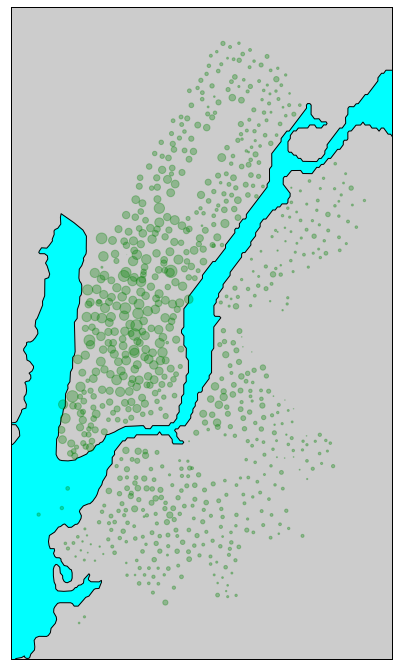

In [4]:
stationsmap(df, "start")

And here is a map where bigger point denotes more ended trips at the station.

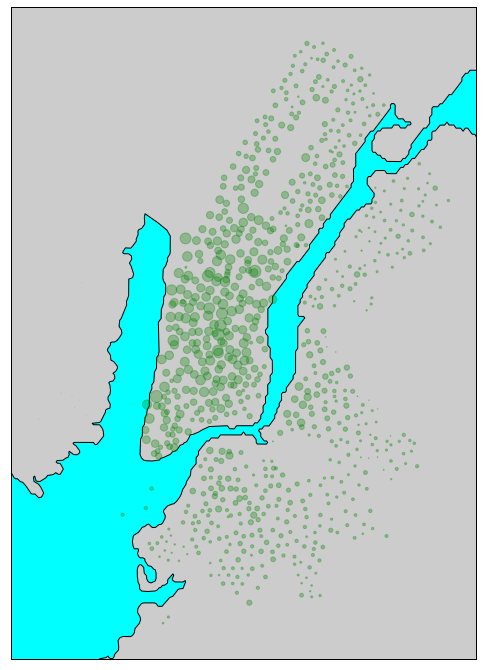

In [5]:
stationsmap(df, "end")

We clearly see that most rides do start and end in Manhattan. So why not use Manhattan distance? Google says that Manhattan grid is rotated by $29^{\circ}$ relatively to north-south direction. Knowing it and being able to calculate initial bearing of the trip, we can determine actual distance more precisely.
![title](geometry.png)
So here we have trip from point C to point D. And we know that actual trip was from C to E and then to D. So actual distance was $|CE| + |ED| = |CD| \cdot (sin(\alpha) + cos(\alpha))$  
We can calculate $\alpha$ by finding difference of initial bearing and Manhattan grid rotation angle which is equal to $29^{\circ}$. That's what following functions do, but they're also vectorized so they work fast on pandas dataframe.

In [6]:
def distance(s_lat, s_lng, e_lat, e_lng):
    #length of segment between two points using haversine formula
    # approximate radius of earth in km
    R = 6369.075

    s_lat = np.deg2rad(s_lat)                    
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return 2 * R * np.arcsin(np.sqrt(d))

def bearing(s_lat, s_lng, e_lat, e_lng):
    s_lat = np.deg2rad(s_lat)                    
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    delta = e_lng - s_lng
    a = np.arctan2(np.sin(delta) * np.cos(e_lat), 
                   np.cos(s_lat) * np.sin(e_lat) - np.sin(s_lat) * np.cos(e_lat) * np.cos(delta))
    return (np.rad2deg(a) + 360) % 360

def manhattandistance(df):
    b = bearing(df['start station latitude'], df['start station longitude'], 
                df['end station latitude'], df['end station longitude'])
    d = distance(df['start station latitude'], df['start station longitude'], 
                 df['end station latitude'], df['end station longitude'])
    angle = np.deg2rad((b - 29) % 90)
    return d * (np.sin(angle) + np.cos(angle))

Next we can calculate average speed of each ride.

In [7]:
df['distance'] = manhattandistance(df)
df['speed'] = df['distance'] / df['tripduration'] * 3600

Here we get to the point where we try to determine which factors influence most rider's perfomance. Chunks marked with `# small sets` comment can have a long time of execution, so for plots we are using already processed data uploaded from local csv files. This data was generated from data for six moths: June - November 2019.  
Firstly we check how hour of day affects average speed of riders.

In [8]:
# small sets
df['hour'] = df.starttime.dt.hour
groupedbystarthour = df.groupby("hour")
meanpacesbyhour = groupedbystarthour.mean()['speed']

In [9]:
meanpacesbyhour = pd.read_csv("meanpacesbyhour.csv", index_col = 'hour')['speed']

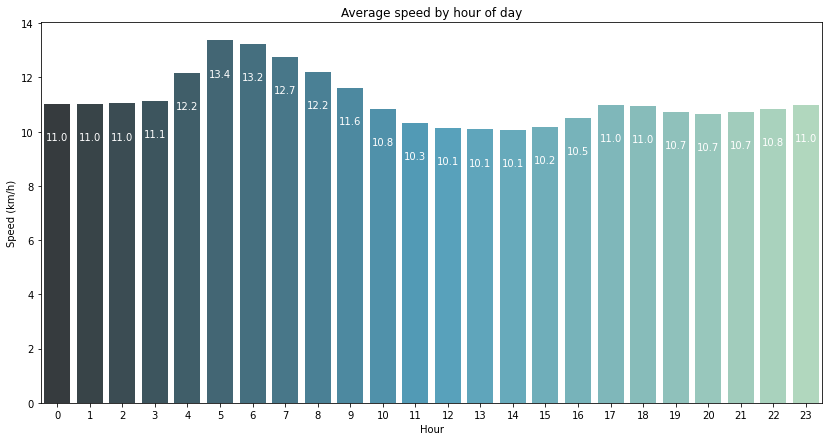

In [11]:
ax = sns.barplot(meanpacesbyhour.index, meanpacesbyhour, palette="GnBu_d")
ax.set_title('Average speed by hour of day', fontsize = 12)
ax.set(xlabel='Hour', ylabel='Speed (km/h)')
rcParams['figure.figsize'] = 12,7
padding = 0.1 * meanpacesbyhour.max()
for index, pace in enumerate(meanpacesbyhour):
    ax.text(index,pace - padding, round(pace, 1), 
            color='white', ha="center", fontsize = 10)
plt.show()

We see that from 5 to 6 am average speed is higher by 30% than at any other hour. It is probably caused by fact that overall traffic is very low at 5-6 am.  
Now let's check how weekday affects average speed.

In [12]:
# small sets
df['weekday'] = df.starttime.dt.weekday
groupedbyweekday = df.groupby('weekday')
meanpacebyweekday = groupedbyweekday.mean()['speed']

In [13]:
meanpacebyweekday = pd.read_csv("meanpacebyweekday.csv", index_col = 'weekday')['speed']

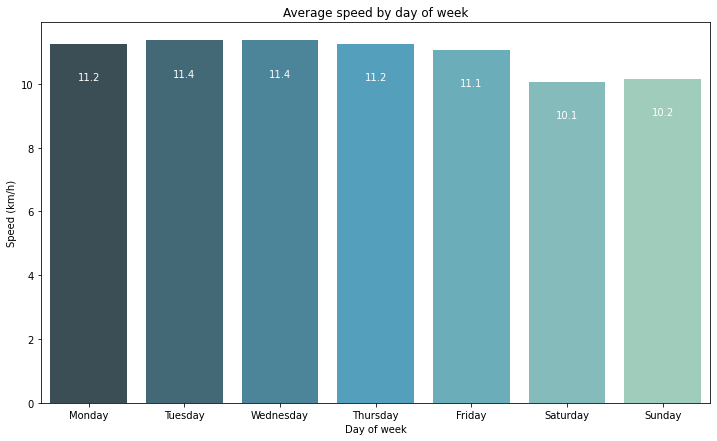

In [14]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(weekdays, meanpacebyweekday, palette="GnBu_d")
ax.set_title('Average speed by day of week', fontsize = 12)
ax.set(xlabel='Day of week', ylabel='Speed (km/h)')
rcParams['figure.figsize'] = 10,7
padding = 0.1 * meanpacebyweekday.max()
for index, pace in enumerate(meanpacebyweekday):
    ax.text(index,pace - padding, round(pace, 1), 
            color='white', ha="center", fontsize = 10)
plt.show()

At weekends average speed falls a little bit - maybe less people are in a hurry to get to work.  
How does gender affect rider's perfomance?

In [15]:
# small sets
mpg = df.drop(df.index[df["gender"] == 0]).groupby("gender").mean()["speed"]

In [16]:
mpg = pd.read_csv("mpg.csv", index_col='gender')['speed']

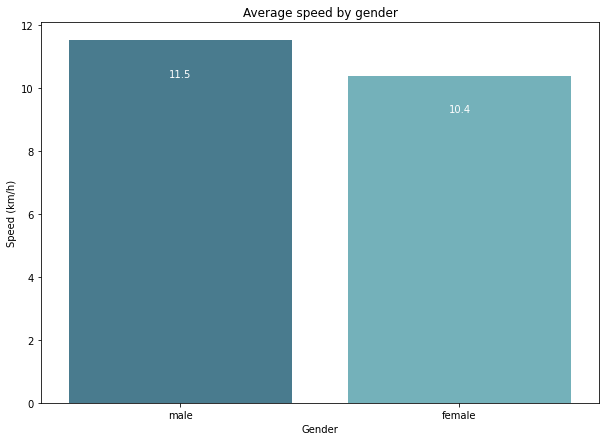

In [17]:
ax = sns.barplot(["male", "female"], mpg, palette="GnBu_d")
ax.set_title('Average speed by gender', fontsize = 12)
ax.set(xlabel='Gender', ylabel='Speed (km/h)')
padding = 0.1 * mpg.max()
for index, pace in enumerate(mpg):
    ax.text(index,pace - padding, round(pace, 1), 
            color='white', ha="center", fontsize = 10)
plt.show()

Men are a little bit faster.  
What about age?

In [18]:
# small sets
mpy = df.groupby("birth year").mean()["speed"]

In [19]:
mpy = pd.read_csv("mpy.csv", index_col='birth year')['speed']

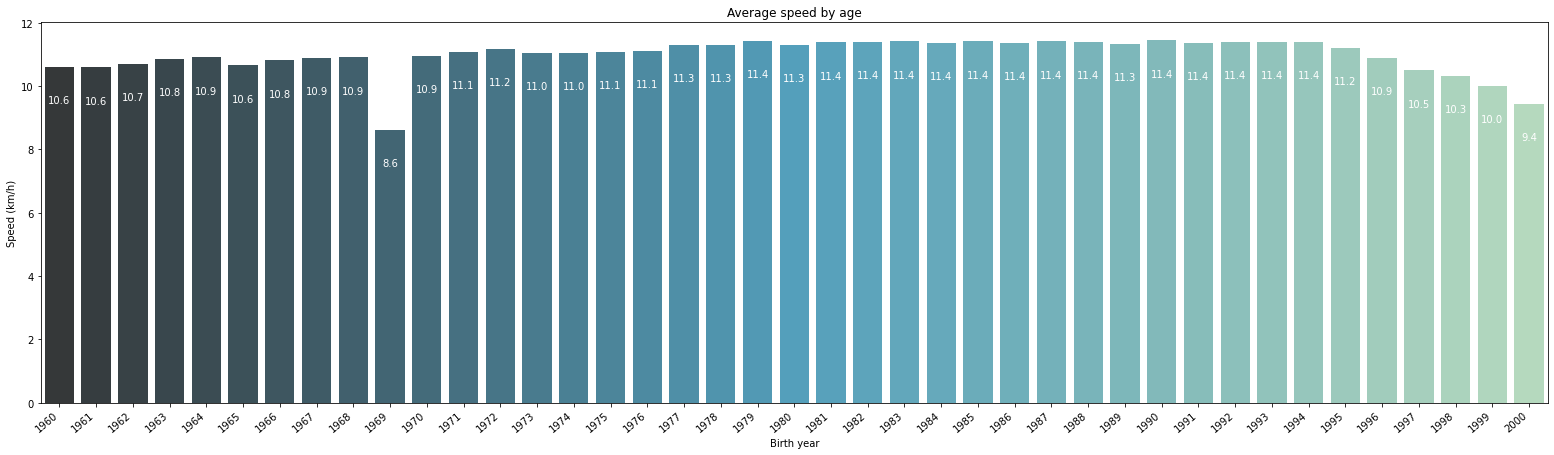

In [21]:
ax = sns.barplot(mpy.index, mpy, palette="GnBu_d")
ax.set_title('Average speed by age', fontsize = 12)
ax.set(xlabel='Birth year', ylabel='Speed (km/h)')
rcParams['figure.figsize'] = 28,7
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')
padding = 0.1 * mpy.max()
for index, pace in enumerate(mpy):
    ax.text(index,pace - padding, round(pace, 1), 
            color='white', ha="center", fontsize = 10)
plt.show()

People who are currently 25-50 years old are the fastest.  
Suming up all factors we considered affect rider's perfomance by up to 10%. Only hour of ride makes significant impact - if ride takes place at 5-6 am, it will be probably up to 30% faster than during the rest of the day. 